# Predicting Taxi Passenger Generosity: A Machine Learning Model for Tip Behavior

**The main dataset is from New York City Taxi & Limousine Commission. The goal is to build a model to predict whether a taxi customer is a generous tipper.**

## 1. Packages and Libraries

In [4]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance

import pickle 

pd.options.mode.chained_assignment = None

## 2. Datasets

In [5]:
# Load datasets
pd.set_option('display.max_columns', None)
df0 = pd.read_csv('2017_Taxi.csv')
nyc_preds_means = pd.read_csv('predicted_means.csv')

In [6]:
df0.head(10)

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,24870114,2,03/25/2017 8:55:43 AM,03/25/2017 9:09:47 AM,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56
1,35634249,1,04/11/2017 2:53:28 PM,04/11/2017 3:19:58 PM,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80
2,106203690,1,12/15/2017 7:26:56 AM,12/15/2017 7:34:08 AM,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75
3,38942136,2,05/07/2017 1:17:59 PM,05/07/2017 1:48:14 PM,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69
4,30841670,2,04/15/2017 11:32:20 PM,04/15/2017 11:49:03 PM,1,4.37,1,N,4,112,2,16.5,0.5,0.5,0.00,0.0,0.3,17.80
5,23345809,2,03/25/2017 8:34:11 PM,03/25/2017 8:42:11 PM,6,2.30,1,N,161,236,1,9.0,0.5,0.5,2.06,0.0,0.3,12.36
6,37660487,2,05/03/2017 7:04:09 PM,05/03/2017 8:03:47 PM,1,12.83,1,N,79,241,1,47.5,1.0,0.5,9.86,0.0,0.3,59.16
7,69059411,2,08/15/2017 5:41:06 PM,08/15/2017 6:03:05 PM,1,2.98,1,N,237,114,1,16.0,1.0,0.5,1.78,0.0,0.3,19.58
8,8433159,2,02/04/2017 4:17:07 PM,02/04/2017 4:29:14 PM,1,1.20,1,N,234,249,2,9.0,0.0,0.5,0.00,0.0,0.3,9.80
9,95294817,1,11/10/2017 3:20:29 PM,11/10/2017 3:40:55 PM,1,1.60,1,N,239,237,1,13.0,0.0,0.5,2.75,0.0,0.3,16.55


In [7]:
nyc_preds_means.head(10)

,mean_duration,mean_distance,predicted_fare
0,22.847222,3.521667,16.434245
1,24.470370,3.108889,16.052218
2,7.250000,0.881429,7.053706
3,30.250000,3.700000,18.731650
4,14.616667,4.435000,15.845642
5,11.855376,2.052258,10.441351
6,59.633333,12.830000,45.374542
7,26.437500,4.022500,18.555128
8,7.873457,1.019259,7.151511
9,10.541111,1.580000,9.122755


In [8]:
# Merge datasets
df0 = df0.merge(nyc_preds_means,
                left_index=True,
                right_index=True)
df0.head()

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,mean_duration,mean_distance,predicted_fare
0,24870114,2,03/25/2017 8:55:43 AM,03/25/2017 9:09:47 AM,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56,22.847222,3.521667,16.434245
1,35634249,1,04/11/2017 2:53:28 PM,04/11/2017 3:19:58 PM,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80,24.470370,3.108889,16.052218
2,106203690,1,12/15/2017 7:26:56 AM,12/15/2017 7:34:08 AM,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75,7.250000,0.881429,7.053706
3,38942136,2,05/07/2017 1:17:59 PM,05/07/2017 1:48:14 PM,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69,30.250000,3.700000,18.731650
4,30841670,2,04/15/2017 11:32:20 PM,04/15/2017 11:49:03 PM,1,4.37,1,N,4,112,2,16.5,0.5,0.5,0.00,0.0,0.3,17.80,14.616667,4.435000,15.845642


In [9]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22699 entries, 0 to 22698
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             22699 non-null  int64  
 1   VendorID               22699 non-null  int64  
 2   tpep_pickup_datetime   22699 non-null  object 
 3   tpep_dropoff_datetime  22699 non-null  object 
 4   passenger_count        22699 non-null  int64  
 5   trip_distance          22699 non-null  float64
 6   RatecodeID             22699 non-null  int64  
 7   store_and_fwd_flag     22699 non-null  object 
 8   PULocationID           22699 non-null  int64  
 9   DOLocationID           22699 non-null  int64  
 10  payment_type           22699 non-null  int64  
 11  fare_amount            22699 non-null  float64
 12  extra                  22699 non-null  float64
 13  mta_tax                22699 non-null  float64
 14  tip_amount             22699 non-null  float64
 15  to

## 3. Feature Engineering

### Target Variable Y

In [10]:
# Customers who pay cash generally have a tip amount of $0. Filtering for only the customers using credit card.
df1 = df0[df0['payment_type']==1]

In [11]:
# Calculating tip percent, Rounding for floating-point arithmetic
df1['tip_percent'] = round(df1['tip_amount'] / (df1['total_amount'] - df1['tip_amount']), 4)
df1['tip_percent']

0        0.2000
1        0.2381
2        0.1986
3        0.3000
5        0.2000
          ...  
22692    0.1995
22693    0.2000
22695    0.2500
22697    0.1504
22698    0.1992
Name: tip_percent, Length: 15265, dtype: float64

In [12]:
# Creating target variable with customer tipping >= 20% as "generous", encoding categorical variable.
df1['generous'] = (df1['tip_percent'] >= 0.20).astype(int)
df1['generous']

0        1
1        1
2        0
3        1
5        1
        ..
22692    0
22693    1
22695    1
22697    0
22698    0
Name: generous, Length: 15265, dtype: int64

### Datetime Management

In [13]:
df1['tpep_pickup_datetime'] = pd.to_datetime(df1['tpep_pickup_datetime'], format='%m/%d/%Y %I:%M:%S %p')
df1['tpep_dropoff_datetime'] = pd.to_datetime(df1['tpep_dropoff_datetime'], format='%m/%d/%Y %I:%M:%S %p')
df1['tpep_pickup_datetime']

0       2017-03-25 08:55:43
1       2017-04-11 14:53:28
2       2017-12-15 07:26:56
3       2017-05-07 13:17:59
5       2017-03-25 20:34:11
                ...        
22692   2017-07-16 03:22:51
22693   2017-08-10 22:20:04
22695   2017-08-06 16:43:59
22697   2017-07-15 12:56:30
22698   2017-03-02 13:02:49
Name: tpep_pickup_datetime, Length: 15265, dtype: datetime64[ns]

In [14]:
# Creating a day column with the day of the week when passengers were picked up
df1['day'] = df1['tpep_pickup_datetime'].dt.day_name().str.lower()
df1["day"]

0        saturday
1         tuesday
2          friday
3          sunday
5        saturday
           ...   
22692      sunday
22693    thursday
22695      sunday
22697    saturday
22698    thursday
Name: day, Length: 15265, dtype: object

**Defining four bins representing time of day: 
am_rush = [06:00–10:00)  
daytime = [10:00–16:00)  
pm_rush = [16:00–20:00)  
nighttime = [20:00–06:00)  
Creating four columns, containing binary values indicating whether a trip began during the time** 

In [15]:
df1["am_rush"] = df1['tpep_pickup_datetime'].dt.hour
df1["daytime"] = df1['tpep_pickup_datetime'].dt.hour
df1["pm_rush"] = df1['tpep_pickup_datetime'].dt.hour
df1["nighttime"] = df1['tpep_pickup_datetime'].dt.hour

In [16]:
def am_rush(hour):
    if 6 <= hour['am_rush'] < 10:
        val = 1
    else:
        val = 0
    return val
    
df1['am_rush'] = df1.apply(am_rush, axis=1)

In [17]:
def daytime(hour):
    if 10 <= hour['daytime'] < 16:
        val = 1
    else:
        val = 0
    return val
df1['daytime'] = df1.apply(daytime, axis=1)

In [18]:
def pm_rush(hour):
    if 16 <= hour['pm_rush'] < 20:
        val = 1
    else:
        val = 0
    return val
df1['pm_rush'] = df1.apply(pm_rush, axis=1)

In [19]:
def nighttime(hour):
    if 20 <= hour['nighttime'] < 24:
        val = 1
    elif 0 <= hour['nighttime'] < 6:
        val = 1
    else:
        val = 0
    return val
df1['nighttime'] = df1.apply(nighttime, axis=1)
df1['nighttime'].head(5)

0    0
1    0
2    0
3    0
5    1
Name: nighttime, dtype: int64

In [20]:
# Creating a month column with abbreviated anem of the month when pasengers were picked up
df1['month'] = df1['tpep_pickup_datetime'].dt.strftime('%b').str.lower()

In [21]:
# Comparing to the originating df0, 8 columns were added: tip_percent, generous, day, am_rush, daytime, pm_rush, nighttime, month
df1.head()

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,mean_duration,mean_distance,predicted_fare,tip_percent,generous,day,am_rush,daytime,pm_rush,nighttime,month
0,24870114,2,2017-03-25 08:55:43,2017-03-25 09:09:47,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56,22.847222,3.521667,16.434245,0.2000,1,saturday,1,0,0,0,mar
1,35634249,1,2017-04-11 14:53:28,2017-04-11 15:19:58,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80,24.470370,3.108889,16.052218,0.2381,1,tuesday,0,1,0,0,apr
2,106203690,1,2017-12-15 07:26:56,2017-12-15 07:34:08,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75,7.250000,0.881429,7.053706,0.1986,0,friday,1,0,0,0,dec
3,38942136,2,2017-05-07 13:17:59,2017-05-07 13:48:14,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69,30.250000,3.700000,18.731650,0.3000,1,sunday,0,1,0,0,may
5,23345809,2,2017-03-25 20:34:11,2017-03-25 20:42:11,6,2.30,1,N,161,236,1,9.0,0.5,0.5,2.06,0.0,0.3,12.36,11.855376,2.052258,10.441351,0.2000,1,saturday,0,0,0,1,mar


### Irrelevant Columns Removal

In [22]:
# The following columns dropped are either irrelevant, redundant, or won't be available when the model is deployed
drop_cols = ['Unnamed: 0', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
             'payment_type', 'trip_distance', 'store_and_fwd_flag', 'payment_type',
             'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
             'improvement_surcharge', 'total_amount', 'tip_percent']

df1 = df1.drop(drop_cols, axis=1)
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15265 entries, 0 to 22698
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   VendorID         15265 non-null  int64  
 1   passenger_count  15265 non-null  int64  
 2   RatecodeID       15265 non-null  int64  
 3   PULocationID     15265 non-null  int64  
 4   DOLocationID     15265 non-null  int64  
 5   mean_duration    15265 non-null  float64
 6   mean_distance    15265 non-null  float64
 7   predicted_fare   15265 non-null  float64
 8   generous         15265 non-null  int64  
 9   day              15265 non-null  object 
 10  am_rush          15265 non-null  int64  
 11  daytime          15265 non-null  int64  
 12  pm_rush          15265 non-null  int64  
 13  nighttime        15265 non-null  int64  
 14  month            15265 non-null  object 
dtypes: float64(3), int64(10), object(2)
memory usage: 1.9+ MB


### Variable Encoding

**Converting numberical columns that contain categorical information to string, then to binary using one-hot encoding.**

In [23]:
cols_to_str = ['RatecodeID', 'PULocationID', 'DOLocationID', 'VendorID']
for col in cols_to_str:
    df1[col] = df1[col].astype('str')
# Converting categoricals to binary/dummies
df2 = pd.get_dummies(df1, drop_first=True)
df2

,passenger_count,mean_duration,mean_distance,predicted_fare,generous,am_rush,daytime,pm_rush,nighttime,VendorID_2,RatecodeID_2,RatecodeID_3,RatecodeID_4,RatecodeID_5,RatecodeID_99,PULocationID_10,PULocationID_100,PULocationID_106,PULocationID_107,PULocationID_112,PULocationID_113,PULocationID_114,PULocationID_116,PULocationID_12,PULocationID_123,PULocationID_125,PULocationID_127,PULocationID_128,PULocationID_129,PULocationID_13,PULocationID_130,PULocationID_131,PULocationID_132,PULocationID_133,PULocationID_134,PULocationID_135,PULocationID_137,PULocationID_138,PULocationID_140,PULocationID_141,PULocationID_142,PULocationID_143,PULocationID_144,PULocationID_145,PULocationID_146,PULocationID_148,PULocationID_151,PULocationID_152,PULocationID_153,PULocationID_158,PULocationID_161,PULocationID_162,PULocationID_163,PULocationID_164,PULocationID_166,PULocationID_17,PULocationID_170,PULocationID_173,PULocationID_179,PULocationID_181,PULocationID_186,PULocationID_188,PULocationID_189,PULocationID_190,PULocationID_193,PULocationID_196,PULocationID_208,PULocationID_209,PULocationID_211,PULocationID_213,PULocationID_216,PULocationID_218,PULocationID_223,PULocationID_224,PULocationID_225,PULocationID_226,PULocationID_229,PULocationID_230,PULocationID_231,PULocationID_232,PULocationID_233,PULocationID_234,PULocationID_236,PULocationID_237,PULocationID_238,PULocationID_239,PULocationID_24,PULocationID_243,PULocationID_244,PULocationID_246,PULocationID_247,PULocationID_249,PULocationID_25,PULocationID_255,PULocationID_256,PULocationID_258,PULocationID_260,PULocationID_261,PULocationID_262,PULocationID_263,PULocationID_264,PULocationID_265,PULocationID_28,PULocationID_33,PULocationID_35,PULocationID_36,PULocationID_37,PULocationID_4,PULocationID_40,PULocationID_41,PULocationID_42,PULocationID_43,PULocationID_45,PULocationID_48,PULocationID_49,PULocationID_50,PULocationID_52,PULocationID_57,PULocationID_61,PULocationID_62,PULocationID_65,PULocationID_66,PULocationID_68,PULocationID_7,PULocationID_70,PULocationID_74,PULocationID_75,PULocationID_79,PULocationID_80,PULocationID_82,PULocationID_87,PULocationID_88,PULocationID_90,PULocationID_91,PULocationID_92,PULocationID_93,PULocationID_95,PULocationID_97,DOLocationID_10,DOLocationID_100,DOLocationID_102,DOLocationID_106,DOLocationID_107,DOLocationID_11,DOLocationID_112,DOLocationID_113,DOLocationID_114,DOLocationID_116,DOLocationID_117,DOLocationID_118,DOLocationID_119,DOLocationID_12,DOLocationID_120,DOLocationID_121,DOLocationID_123,DOLocationID_124,DOLocationID_125,DOLocationID_126,DOLocationID_127,DOLocationID_129,DOLocationID_13,DOLocationID_130,DOLocationID_131,DOLocationID_132,DOLocationID_133,DOLocationID_134,DOLocationID_135,DOLocationID_136,DOLocationID_137,DOLocationID_138,DOLocationID_14,DOLocationID_140,DOLocationID_141,DOLocationID_142,DOLocationID_143,DOLocationID_144,DOLocationID_145,DOLocationID_146,DOLocationID_147,DOLocationID_148,DOLocationID_15,DOLocationID_151,DOLocationID_152,DOLocationID_153,DOLocationID_157,DOLocationID_158,DOLocationID_159,DOLocationID_16,DOLocationID_160,DOLocationID_161,DOLocationID_162,DOLocationID_163,DOLocationID_164,DOLocationID_166,DOLocationID_168,DOLocationID_169,DOLocationID_17,DOLocationID_170,DOLocationID_173,DOLocationID_174,DOLocationID_175,DOLocationID_177,DOLocationID_178,DOLocationID_179,DOLocationID_180,DOLocationID_181,DOLocationID_182,DOLocationID_183,DOLocationID_186,DOLocationID_188,DOLocationID_189,DOLocationID_19,DOLocationID_192,DOLocationID_193,DOLocationID_194,DOLocationID_195,DOLocationID_196,DOLocationID_197,DOLocationID_198,DOLocationID_200,DOLocationID_202,DOLocationID_208,DOLocationID_209,DOLocationID_21,DOLocationID_210,DOLocationID_211,DOLocationID_212,DOLocationID_213,DOLocationID_216,DOLocationID_217,DOLocationID_218,DOLocationID_22,DOLocationID_220,DOLocationID_223,DOLocationID_224,DOLocationID_225,DOLocationID_226,DOLocationID_228,DOLocationID_229,DOLocationID_23,DOLocationID_230,DOLocationID_231,DOLocationID_232,

**There are only a few hundred columns here, scalability concern is low. We will not need to drop less frequent categories or perform hashing.**

### Evaluation metric

In [24]:
# Evaluate class balance of 'generous' col
df2['generous'].value_counts(normalize=True)

generous
0    0.511169
1    0.488831
Name: proportion, dtype: float64

**The dataset is nearly balanced.**

### Ethics

* False positives (the model predicts a tip >= 20%, but the customer gives less)
* False negatives (the model predicts a tip < 20%, but the customer gives more)

If some forms of the prediction of this model is visible to the drivers:
False positives are worse for cab drivers, because they would pick up a customer expecting a good tip and then not receive one.
False negatives are worse for customers, because a customer might not be picked up even though he/she would tip generously

**Our metric, which is F<sub>1</sub> score, should place equal weight on true postives and false positives, and so therefore on precision and recall.**

## 4. Modeling

### Data Split

In [25]:
# Isolate target variable
y = df2['generous']
# Isolate the features
X = df2.drop('generous', axis=1)

# Putting 20% of the samples into test, stratifing data, setting random state
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=27)

### Random Forest Model

In [26]:
rf = RandomForestClassifier(random_state=27, n_jobs=-1)

cv_params = {
    # Number of trees
    'n_estimators': [100, 300],
    # Tree depth – Overfitting control 
    'max_depth': [None, 10, 20],
    # How many samples to consider for a split
    'min_samples_split': [2, 10],
    # Minimum samples per leaf – 1 = pure, higher = smoother
    'min_samples_leaf': [1, 4],
    # Number of features trying at each split
    'max_features': ['sqrt', 0.3],
    # Subsample rows for each tree
    'max_samples': [None, 0.7],
    # Potential class imbalance 
    'class_weight': [None, 'balanced']
}

scoring = ['accuracy', 'precision', 'recall', 'f1']

rf_grid = GridSearchCV(
    estimator=rf,
    param_grid=cv_params,
    scoring=scoring,
    cv=4,
    refit='f1',
    n_jobs=-1
)

In [27]:
%%time
rf_grid.fit(X_train, y_train)

CPU times: total: 6.27 s
Wall time: 6min 39s


,estimator,RandomForestC...ndom_state=27)
,param_grid,"{'class_weight': [None, 'balanced'], 'max_depth': [None, 10, ...], 'max_features': ['sqrt', 0.3], 'max_samples': [None, 0.7], ...}"
,scoring,"['accuracy', 'precision', ...]"
,n_jobs,-1
,refit,'f1'
,cv,4
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,100


In [28]:
rf_grid.best_score_

np.float64(0.7365020307243173)

In [29]:
rf_grid.best_params_

{'class_weight': None,
 'max_depth': 10,
 'max_features': 0.3,
 'max_samples': 0.7,
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 100}

In [30]:
# Function to oupt all scores of the model
def make_results(model_name:str, model_object, metric:str):
    # Dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {'precision': 'mean_test_precision',
                 'recall': 'mean_test_recall',
                 'f1': 'mean_test_f1',
                 'accuracy': 'mean_test_accuracy',
                 }

    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract Accuracy, precision, recall, and f1 score from that row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    table = pd.DataFrame({'model': [model_name],
                        'precision': [precision],
                        'recall': [recall],
                        'F1': [f1],
                        'accuracy': [accuracy],
                        },
                       )

    return table

In [31]:
results = make_results('RF CV', rf_grid, 'f1')
results

,model,precision,recall,F1,accuracy
0,RF CV,0.693205,0.785593,0.736502,0.725188


**The Cross Validation shows some valid prediction power. But I will train a different model and pick the best one.**

In [32]:
def get_test_scores(model_name:str, preds, y_test_data):
    
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                        'precision': [precision],
                        'recall': [recall],
                        'F1': [f1],
                        'accuracy': [accuracy]
                        })

    return table

In [33]:
rf_preds = rf_grid.best_estimator_.predict(X_test)
rf_test_scores = get_test_scores('RF test', rf_preds, y_test)
results = pd.concat([results, rf_test_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF CV,0.693205,0.785593,0.736502,0.725188
0,RF test,0.698460,0.790214,0.741509,0.730757


**Test results are slightly higher comparing to CV results. The Random Forest model achieves an F1 score of 0.74 on the test set, indicating acceptable performance given the inherent noise and unpredictability of tipping behavior. In production systems, it is difficult for behavioral predictions to exceed 0.80 F1 due to missing contextual factors not present in the dataset such as customer mood, driver-customer interactions. Therefore, such a performance could be considered useful if it meaningfully improves business outcomes.**

### XGBoost Model

In [34]:
xgb = XGBClassifier(objective='binary:logistic', random_state=0, n_jobs=-1, eval_metric='logloss',tree_method='hist')

#This grid is a compromise from a larger grid, as my local machine does not have enough computing power. 
cv_params = {
    'learning_rate': [0.05, 0.1],          
    # Tree depth: shallow/medium/deeper
    'max_depth': [3, 5, 7],                
    # Overfitting control
    'min_child_weight': [1, 3],            
    # Number of trees
    'n_estimators': [300, 500],           
    # Row subsampling
    'subsample': [0.8, 1.0],               
    # Column subsampling per tree
    'colsample_bytree': [0.8, 1.0],        
    # Regularization knobs
    'gamma': [0, 0.5],                          
    'reg_lambda': [1.0],      #L2             
    'reg_alpha': [0, 0.01]    #L1            
}

scoring = ['accuracy', 'precision', 'recall', 'f1']

xgb_grid = GridSearchCV(
    estimator=xgb,
    param_grid=cv_params,
    scoring=scoring,
    cv=4,
    refit='f1',
    n_jobs=-1,
    verbose=1
)

In [35]:
%%time
xgb_grid.fit(X_train, y_train)

Fitting 4 folds for each of 384 candidates, totalling 1536 fits
CPU times: total: 15.1 s
Wall time: 6min 39s


,estimator,"XGBClassifier...ree=None, ...)"
,param_grid,"{'colsample_bytree': [0.8, 1.0], 'gamma': [0, 0.5], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 5, ...], ...}"
,scoring,"['accuracy', 'precision', ...]"
,n_jobs,-1
,refit,'f1'
,cv,4
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'binary:logistic'


In [36]:
xgb_grid.best_score_

np.float64(0.7343495003401214)

In [37]:
xgb_grid.best_params_

{'colsample_bytree': 1.0,
 'gamma': 0.5,
 'learning_rate': 0.05,
 'max_depth': 3,
 'min_child_weight': 3,
 'n_estimators': 300,
 'reg_alpha': 0,
 'reg_lambda': 1.0,
 'subsample': 0.8}

In [39]:
xgb_cv_results = make_results('XGB CV', xgb_grid, 'f1')
results = pd.concat([results, xgb_cv_results], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF CV,0.693205,0.785593,0.736502,0.725188
0,RF test,0.698460,0.790214,0.741509,0.730757
0,XGB CV,0.692520,0.781574,0.734350,0.723551


In [41]:
xgb_preds = xgb_grid.best_estimator_.predict(X_test)
xgb_test_scores = get_test_scores('XGB test', xgb_preds, y_test)
results = pd.concat([results, xgb_test_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF CV,0.693205,0.785593,0.736502,0.725188
0,RF test,0.698460,0.790214,0.741509,0.730757
0,XGB CV,0.692520,0.781574,0.734350,0.723551
0,XGB test,0.698516,0.788874,0.740951,0.730429


**Since we chose F1 score as the optimization metric, the two models have identical performances, with Random Forest being the slightly better one. XGBoost is a high-capacity model that requires careful hyperparameter tuning to avoid overfitting noisy signals. However, the dataset contains many sparse dummy variables and significant behavioral noise. Also, XGBoost is caculated mostly sequentially, making a larger hyperparameter search space impractical under computational constraints. Therefore, XGBoost was unable to reach its optimal configuration. In contrast, Random Forest is more robust to noise and performs well even with minimal tuning, which explains why it outperformed XGBoost in this case.**

### Random Forest Confusion Matrix

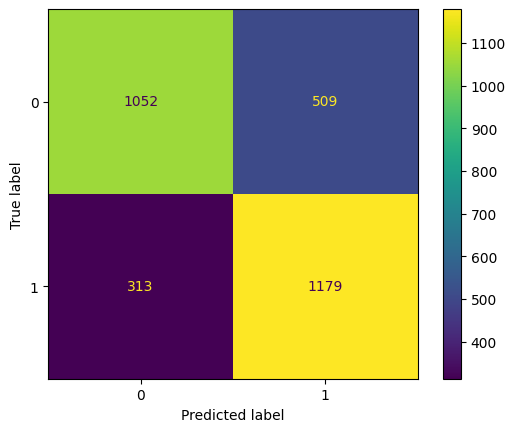

In [44]:
# Generate array of values for confusion matrix
cm = confusion_matrix(y_test, rf_preds, labels=rf_grid.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=rf_grid.classes_, 
                             )
disp.plot(values_format='');

**As the champion model, it is much more likely to predict a false positive than false negative. In another word,, Type I errors are more common. In production this could be less desirable. In more cases drivers would be disaapointed by a low tip, expecting a generous one, rather than be pleasantly surprised by a generous tip.**

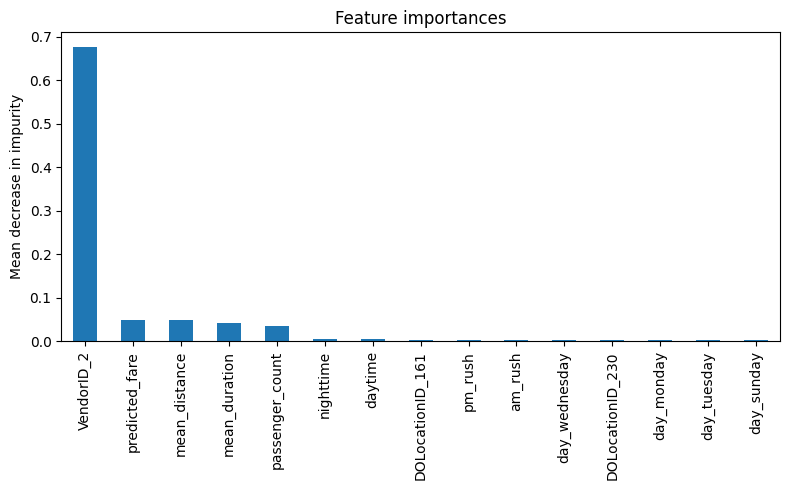

In [48]:
importances = rf_grid.best_estimator_.feature_importances_
rf_importances = pd.Series(importances, index=X_test.columns)
rf_importances = rf_importances.sort_values(ascending=False)[:15]

fig, ax = plt.subplots(figsize=(8,5))
rf_importances.plot.bar(ax=ax)
ax.set_title('Feature importances')
ax.set_ylabel('Mean decrease in impurity')
fig.tight_layout();

**We know that VendorID, predicted_fare, mean_distance, mean_duration, and passenger count are the most important features, but we are not sure how they influence tipping. Random forrest is not the most transparent machine learning algorithum. Further statistical tests on features such as VendorID might reveal more insights.**

## 4. Conclusion

**Overall it is a good model. It correctly predicts about 73% of the customers, which is 46% better than random guessing. Addtionally, we could add more features, for example people are more liekly to round up their tip, which could affects our calculation. In the future, another model that should be prioritized is LightGBM, which is faster and handles large categorical variable better. With a large dataset and buedget to cloud computing, we could also test out other machine learning models suchn as CatBoost and TabNet.**